<a href="https://colab.research.google.com/github/DragomirBozoki/ECG-Classification/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.utils import resample
import gdown

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, recall_score

In [ ]:
file_id = '1Vxu5iUjqrN8S8PEWELO5PNenovA2aw5F'
output = 'data.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (original): https://drive.google.com/uc?id=1Vxu5iUjqrN8S8PEWELO5PNenovA2aw5F
From (redirected): https://drive.google.com/uc?id=1Vxu5iUjqrN8S8PEWELO5PNenovA2aw5F&confirm=t&uuid=b2491c54-64c4-4d5d-ab57-94b903dde2d6
To: /content/data.zip
100%|██████████| 104M/104M [00:03<00:00, 33.1MB/s] 


['mitbih_test.csv',
 'mitbih_train.csv',
 'ptbdb_abnormal.csv',
 'ptbdb_normal.csv']

**Preprocessing**

In [ ]:
df_train_un = pd.read_csv('/content/mitbih_train.csv', header = None) # _un - nastavak da je unfiltered dataset
df_test_un = pd.read_csv('/content/mitbih_test.csv', header = None) # _un - nastavak da je unfiltered dataset

In [ ]:
df_test_un.iloc[:, 187].unique()

array([0., 1., 2., 3., 4.])


LF filter za uklananje šuma sa snimka **bold text**

In [ ]:
from scipy.signal import butter, filtfilt
sampling_rate = 125

def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
    nyquist_freq = 0.5 * fs
    normal_cutoff = cutoff_freq / nyquist_freq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

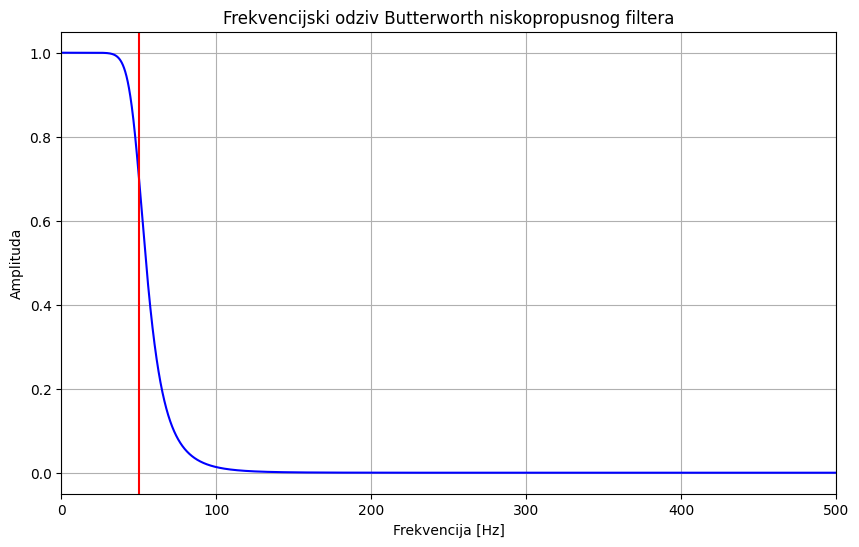

In [ ]:
from scipy.signal import butter, freqz
import numpy as np
import matplotlib.pyplot as plt

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

cutoff_freq = 50.0  # cutoff frekvencija u Hz
fs = 1000.0  # uzorkovanje u Hz
order = 6  # red filtera

b, a = butter_lowpass(cutoff_freq, fs, order)
w, h = freqz(b, a, worN=8000)

plt.figure(figsize=(10, 6))
plt.plot(0.5 * fs * w / np.pi, np.abs(h), 'b')
plt.axvline(cutoff_freq, color='r')
plt.xlim(0, 0.5 * fs)
plt.title("Frekvencijski odziv Butterworth niskopropusnog filtera")
plt.xlabel('Frekvencija [Hz]')
plt.ylabel('Amplituda')
plt.grid()
plt.show()

In [ ]:
df_test_un.tail()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
21887,0.928736,0.871264,0.804598,0.742529,0.650575,0.535632,0.394253,0.250575,0.140230,0.102299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21888,0.802691,0.692078,0.587444,0.446936,0.318386,0.189836,0.118087,0.077728,0.112108,0.152466,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21889,1.000000,0.967359,0.620178,0.347181,0.139466,0.089021,0.103858,0.100890,0.106825,0.100890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21890,0.984127,0.567460,0.607143,0.583333,0.607143,0.575397,0.575397,0.488095,0.392857,0.238095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
21891,0.973970,0.913232,0.865510,0.823210,0.746204,0.642082,0.547722,0.426247,0.325380,0.279826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0


In [ ]:
cutoff_frequency = 50

column_187 = df_train_un.iloc[:, 187]
df_train1 = df_train_un.drop(columns = 187, axis = 1)

df_train1 = butter_lowpass_filter(df_train1.to_numpy(), cutoff_frequency, sampling_rate)

df_train1 = pd.DataFrame(df_train1)
df_train1.insert(187, df_train_un.columns[187], column_187)

df_train = df_train1
df_train = pd.DataFrame(df_train1)
df_train

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977949,0.933857,0.668537,0.260197,0.140403,0.201587,0.146254,0.087052,0.060843,0.045115,...,-2.523701e-09,3.041301e-09,-2.416295e-09,1.201774e-09,2.846729e-11,-8.716792e-10,1.173752e-09,-1.002711e-09,5.586825e-10,0.0
1,0.960105,0.855660,0.475026,0.180027,0.110526,0.111462,0.109498,0.082935,0.075774,0.083290,...,-1.276418e-06,2.392247e-06,-2.391487e-06,1.617438e-06,-5.579442e-07,-3.566349e-07,8.748273e-07,-9.504035e-07,6.944057e-07,0.0
2,0.999989,0.652078,0.198995,0.056323,0.081856,0.052958,0.057164,0.048269,0.045378,0.056130,...,-1.084387e-09,8.661192e-10,-4.348492e-10,-4.565192e-12,3.075519e-10,-4.180094e-10,3.592574e-10,-2.021310e-10,2.755260e-11,0.0
3,0.925493,0.679408,0.517033,0.306280,0.166206,0.102288,0.054823,0.069160,0.065230,0.054279,...,-1.854231e-10,-8.027484e-10,1.227591e-09,-1.124839e-09,6.898100e-10,-1.652630e-10,-2.516169e-10,4.589421e-10,-4.538122e-10,0.0
4,0.967138,0.996153,0.837782,0.578620,0.364802,0.242454,0.149537,0.087596,0.117188,0.151258,...,-9.392022e-06,6.509256e-06,-2.407560e-06,-1.212616e-06,3.328753e-06,-3.718305e-06,2.784871e-06,-1.235653e-06,-2.398844e-07,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807082,0.499826,0.528143,0.539610,0.482999,0.488895,0.455913,0.392449,0.291510,0.127703,...,4.642929e-08,-2.535547e-08,2.559462e-09,1.406037e-08,-2.102811e-08,1.905438e-08,-1.152068e-08,2.567245e-09,4.476047e-09,4.0
87550,0.718302,0.604976,0.486591,0.362100,0.230622,0.121805,0.049124,0.004747,-0.003292,0.016451,...,1.072857e-07,4.466771e-07,-6.859209e-07,6.297974e-07,-3.871998e-07,9.386613e-08,1.397275e-07,-2.563090e-07,2.539955e-07,4.0
87551,0.906064,0.627238,0.590993,0.581786,0.523856,0.488151,0.439125,0.392437,0.319100,0.193713,...,1.252609e-06,-7.141249e-07,1.102154e-07,3.437930e-07,-5.471671e-07,5.111001e-07,-3.207124e-07,8.486461e-08,1.062614e-07,4.0
87552,0.858234,0.685234,0.776596,0.329304,0.091752,0.187427,0.091387,0.127708,0.129496,0.085948,...,1.880378e-07,-1.015321e-07,8.781352e-09,5.831218e-08,-8.593893e-08,7.728404e-08,-4.627758e-08,9.796718e-09,1.868592e-08,4.0


<Axes: title={'center': 'ECG 1. Osobe (Klasa: N) '}>

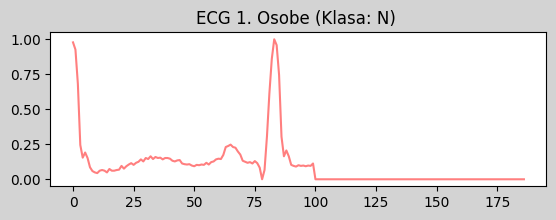

In [ ]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.gcf().patch.set_facecolor('lightgray')

plt.subplot(2,1,1)
df_train_un.iloc[0, :187].plot(title='ECG 1. Osobe (Klasa: N) ', alpha = 0.5, color = 'red')

<Axes: title={'center': 'ECG 1. Osobe (Klasa: Q) '}>

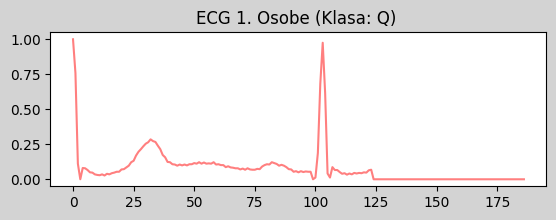

In [ ]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.gcf().patch.set_facecolor('lightgray')

plt.subplot(2,1,1)
df_test_un.iloc[0, :187].plot(title='ECG 1. Osobe (Klasa: Q) ', alpha = 0.5, color = 'red')

In [ ]:
time = 10 # 10sec of data
fs = 360 # frefkencija uzorkovanja

<Axes: title={'center': 'ECG 1. Osobe Filtrirani podaci'}>

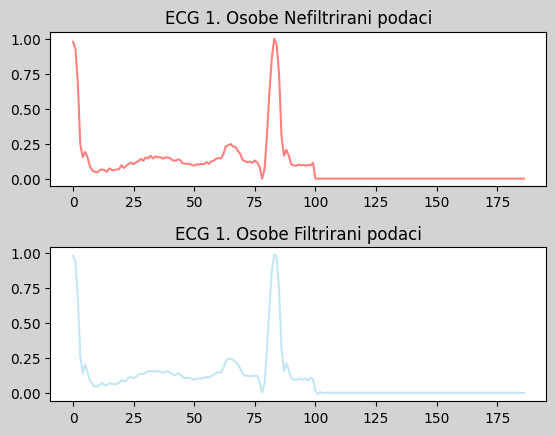

In [ ]:
plt.figure()
plt.subplots_adjust(hspace=0.4)
plt.gcf().patch.set_facecolor('lightgray')

plt.subplot(2,1,1)
df_train_un.iloc[0, :187].plot(title='ECG 1. Osobe Nefiltrirani podaci', alpha = 0.5, color = 'red')

plt.subplot(2,1,2)
df_train.iloc[0, :187].plot(title='ECG 1. Osobe Filtrirani podaci', alpha = 0.5, color = 'skyblue')

In [ ]:
df_train.info()
print('\n')
df_test_un.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21892 entries, 0 to 21891
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 31.4 MB


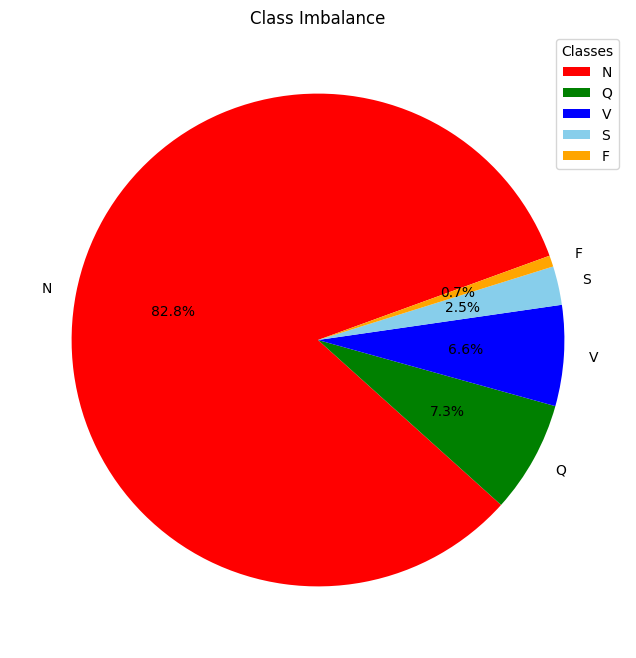

187
0.0    82.772917
4.0     7.345181
2.0     6.610777
1.0     2.539005
3.0     0.732120
Name: proportion, dtype: float64


In [ ]:
output_percentage1 = df_train.iloc[:, 187].value_counts(normalize=True)

labels = ['N', 'Q', 'V', 'S', 'F']

plt.figure(figsize=(8, 8))
plt.pie(output_percentage1, labels=labels, autopct='%1.1f%%', startangle=20, colors=['red','green','blue','skyblue','orange'])
plt.title("Class Imbalance")
plt.legend(labels, title="Classes", loc="best")
plt.show()

print(output_percentage1 * 100)

In [ ]:
df_1 = df_train[df_train.iloc[:, 187] == 1]
df_2 = df_train[df_train.iloc[:, 187] == 2]
df_3 = df_train[df_train.iloc[:, 187] == 3]
df_4 = df_train[df_train.iloc[:, 187] == 4]
df_0 = (df_train[df_train.iloc[:, 187] == 0]).sample(n=20000, random_state=42)

df_1_upsample = resample(df_1, replace=True, n_samples=20000, random_state=123)
df_2_upsample = resample(df_2, replace=True, n_samples=20000, random_state=124)
df_3_upsample = resample(df_3, replace=True, n_samples=20000, random_state=125)
df_4_upsample = resample(df_4, replace=True, n_samples=20000, random_state=126)


df_train = pd.concat([df_0, df_1_upsample, df_2_upsample, df_3_upsample, df_4_upsample])

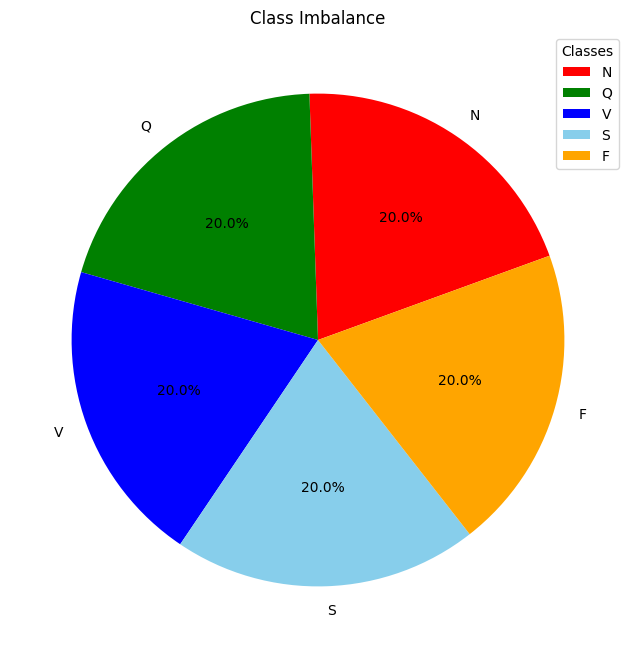

In [ ]:
output_percentage2 = df_train.iloc[:, 187].value_counts(normalize=True)
labels = ['N', 'Q', 'V', 'S', 'F']

plt.figure(figsize=(8, 8))
plt.pie(output_percentage2, labels=labels, autopct='%1.1f%%', startangle=20, colors=['red','green','blue','skyblue','orange'])
plt.title("Class Imbalance")
plt.legend(labels, title="Classes", loc="best")
plt.show()

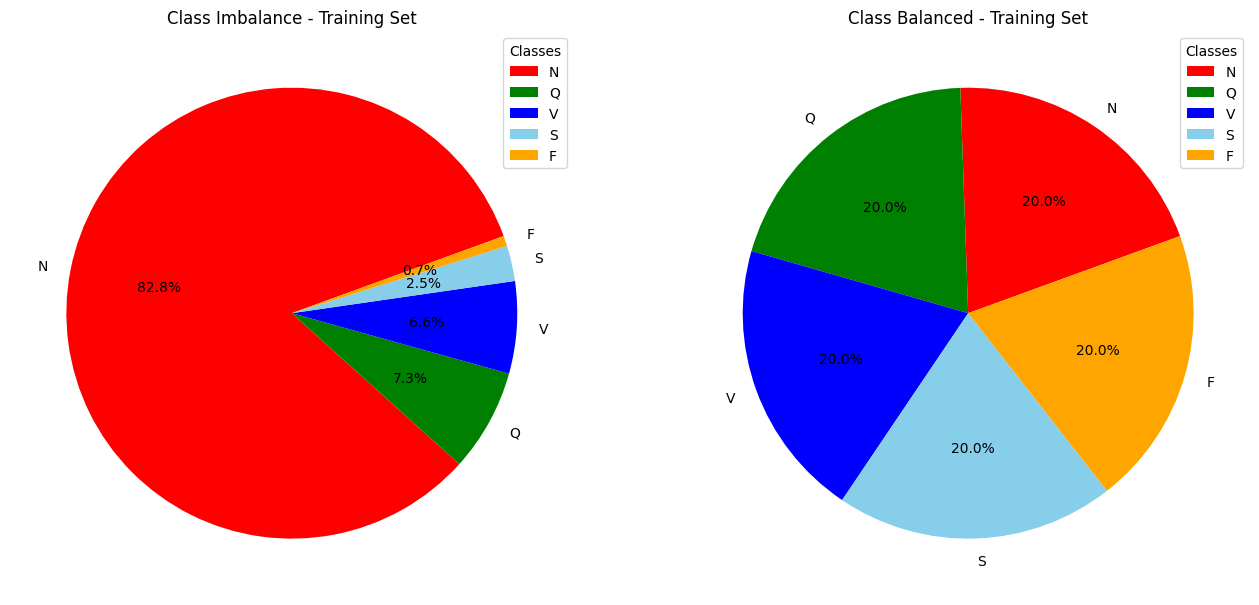

In [ ]:
labels = ['N', 'Q', 'V', 'S', 'F']
colors = ['red', 'green', 'blue', 'skyblue', 'orange']

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Prvi grafikon
axs[0].pie(output_percentage1, labels=labels, autopct='%1.1f%%', startangle=20, colors=colors)
axs[0].set_title("Class Imbalance - Training Set")
axs[0].legend(labels, title="Classes", loc="best")

# Drugi grafikon
axs[1].pie(output_percentage2, labels=labels, autopct='%1.1f%%', startangle=20, colors=colors)
axs[1].set_title("Class Balanced - Training Set")
axs[1].legend(labels, title="Classes", loc="best")

plt.show()

In [ ]:
classes = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
class_descriptions = {
    'N': 'Non-ecotic beats (normal beat)',
    'S': 'Supraventricular ectopic beats',
    'V': 'Ventricular ectopic beats',
    'F': 'Fusion Beats',
    'Q': 'Unknown Beats'
}

In [ ]:
group_classes=df_train.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
group_classes

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
25997,0.978604,0.890209,0.506460,0.307909,0.307534,0.267665,0.234230,0.197556,0.166819,0.145292,...,2.061165e-09,1.340991e-08,-1.978910e-08,1.780755e-08,-1.067464e-08,2.279591e-09,4.274079e-09,-7.430191e-09,7.208108e-09,0.0
73230,0.999971,0.863784,0.224602,-0.029499,0.074945,0.078868,0.110027,0.175651,0.211857,0.178214,...,3.431532e-01,3.413909e-01,3.381545e-01,3.414825e-01,3.430498e-01,3.363577e-01,3.484676e-01,3.597766e-01,3.301186e-01,1.0
77514,0.000009,0.038085,0.142784,0.253599,0.351849,0.455215,0.527016,0.558129,0.569384,0.584841,...,7.379595e-12,1.252549e-11,-2.226185e-11,2.180616e-11,-1.443713e-11,4.661496e-12,3.619451e-12,-8.184544e-12,8.694946e-12,2.0
81030,0.738733,1.009778,0.917966,0.492622,0.230931,0.184273,0.143018,0.136758,0.129913,0.113580,...,-9.917445e-13,-6.885120e-13,1.629658e-12,-1.754528e-12,1.273539e-12,-5.283387e-13,-1.589041e-13,5.836103e-13,-6.888015e-13,3.0
82117,0.720476,0.591172,0.555229,0.543949,0.518731,0.495780,0.463044,0.422931,0.358137,0.250965,...,3.411455e-07,-5.674443e-07,5.406829e-07,-3.472608e-07,1.009188e-07,1.024111e-07,-2.101328e-07,2.166814e-07,-1.509077e-07,4.0


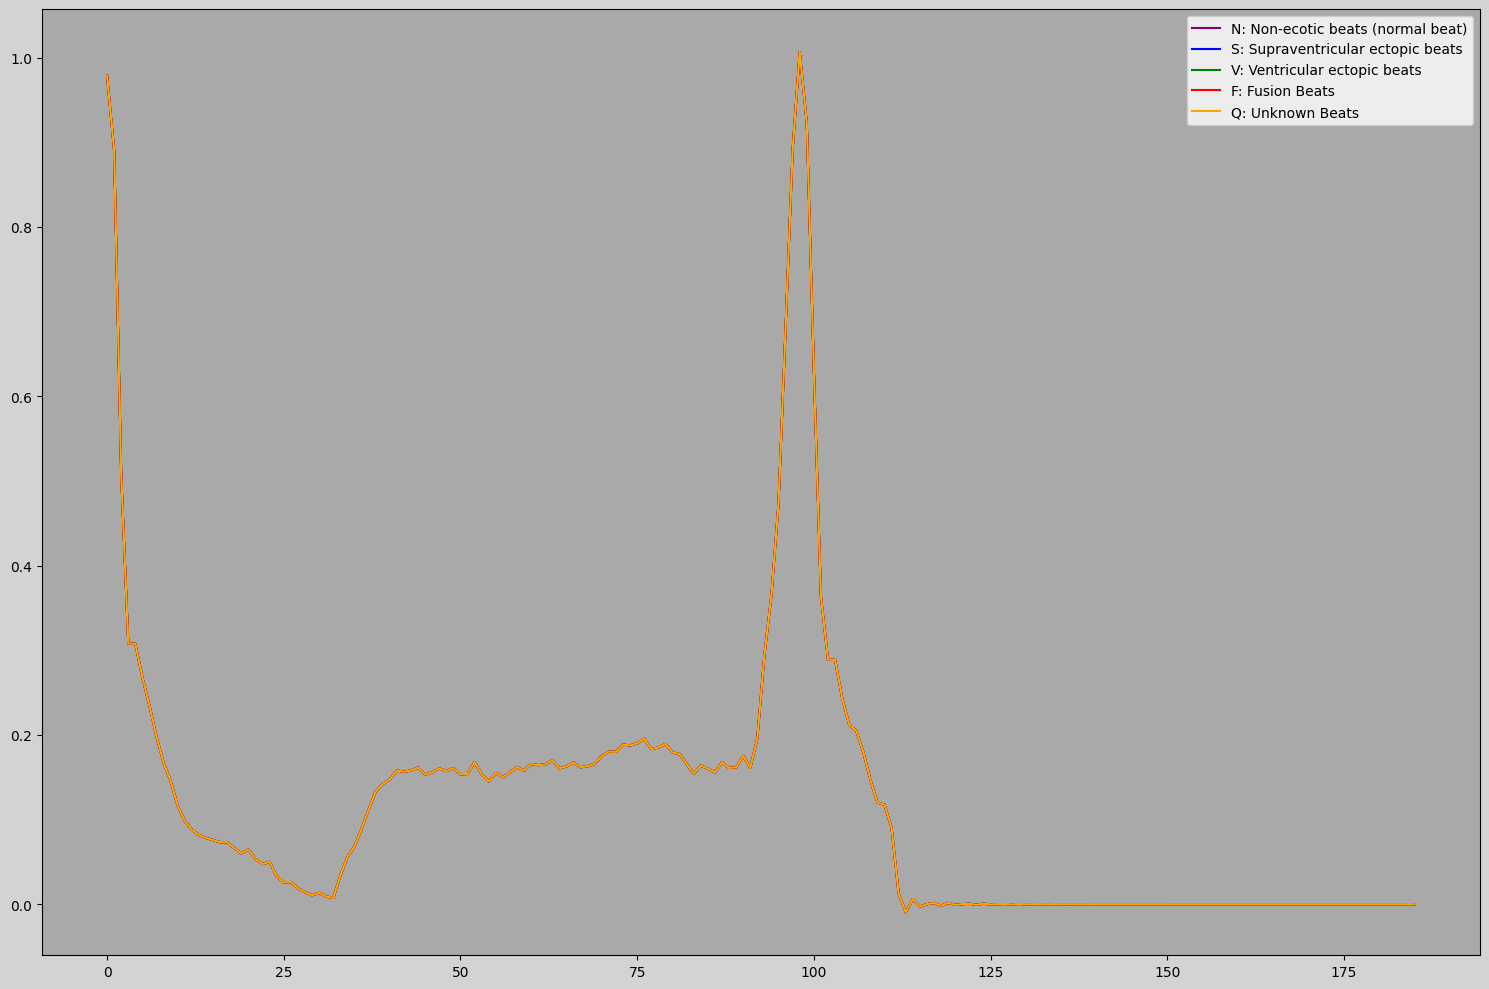

In [ ]:
colors = ['purple', 'blue', 'green', 'red', 'orange']


# Pretpostavimo da imate podatke u grupi 'group_classes'
# i da su klasifikacije i opisi definisani u listama 'classes' i 'class_descriptions'

fig, ax = plt.subplots(figsize=(15, 10))

colors = ['purple', 'blue', 'green', 'red', 'orange']

for i in range(5):
    ax.plot(group_classes.iloc[0, :186], label=f"{classes[i]}: {class_descriptions[classes[i]]}", color=colors[i])

# Dodavanje legende
ax.legend()

# Postavljanje boje pozadine
plt.gcf().patch.set_facecolor('lightgray')

# Poboljšanje izgleda grafika
plt.tight_layout()
fig.patch.set_facecolor('lightgray')  # pozadina figure
ax.set_facecolor('darkgray')  # pozadina grafika
# Prikaz grafika
plt.show()

In [ ]:
X_train1 = df_train.drop(columns = 187, axis = 1)
y_train1 = df_train.iloc[:, 187]

In [ ]:
X_test = df_test_un.drop(columns = 187, axis = 1)
y_test = df_test_un.iloc[:, 187]

In [ ]:
x_train,x_valid,y_train,y_valid=train_test_split(X_train1,y_train1,test_size=0.2, random_state=42)

In [ ]:
scaler = StandardScaler()
x_train_normalized = scaler.fit_transform(x_train)
x_valid_normalized = scaler.transform(x_valid)
x_test_normalized = scaler.fit_transform(X_test)

In [ ]:
print(x_train_normalized.shape)
print(y_train.shape)

(80000, 187)
(80000,)


In [ ]:
y_train.head(20)

80979    3.0
75193    2.0
75735    2.0
61568    0.0
82417    4.0
77614    2.0
81650    4.0
60081    0.0
84749    4.0
49755    0.0
76736    2.0
76346    2.0
72986    1.0
85816    4.0
34556    0.0
3886     0.0
84798    4.0
75953    2.0
80698    3.0
73414    1.0
Name: 187, dtype: float64

## ***Machine Learning Classifiers![rnn.png](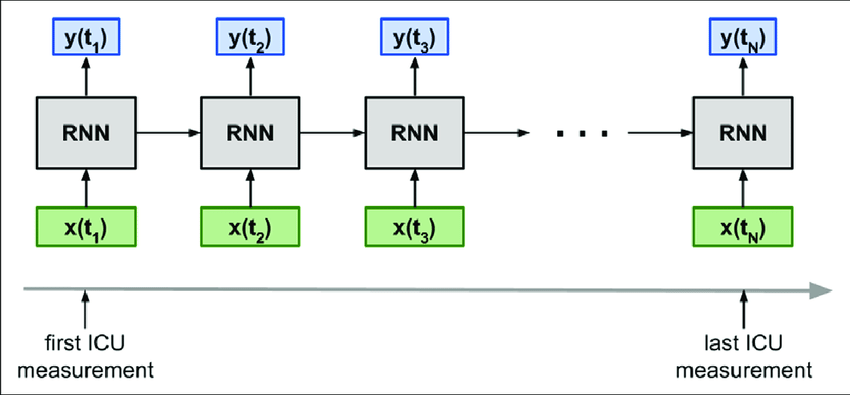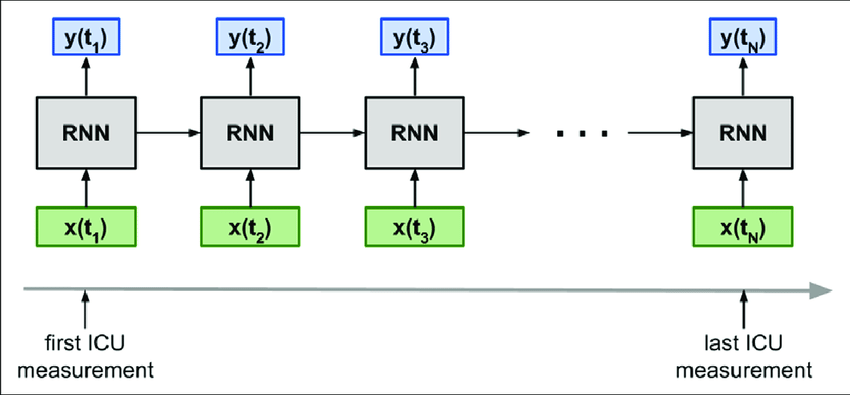)***

# **kNN**

*K-Nearest Neighbour is one of the simplest Machine Learning algorithms based on Supervised Learning technique.
K-NN algorithm assumes the similarity between the new case/data and available cases and put the new case into the category that is most similar to the available categories.*




In [ ]:
from sklearn.neighbors import KNeighborsClassifier as KNN

In [ ]:
scorer = make_scorer(recall_score, average='macro')
parameters =  {
    'n_neighbors': [1],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'metric': ['manhattan']
}

clf_knn = KNN()
clf_knn = GridSearchCV(clf_knn, parameters, scoring=scorer, cv=10, verbose=1)
clf_knn.fit(x_train_normalized[0:40000], y_train[0:40000])

In [ ]:
#print("Best score: ", clf_knn.best_score_)
#print("Best hyperparameters: ", clf_knn.best_params_)

#Best score:  0.9826204781054784
#Best hyperparameters:  {'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 1}

In [ ]:
classifier = KNN(algorithm = 'auto', metric = 'manhattan', n_neighbors =  1)
classifier.fit(x_train_normalized, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=1)

In [ ]:
y_pred = classifier.predict(x_valid_normalized[0:40000])

In [ ]:
labels = ['N','S','V','F','Q']

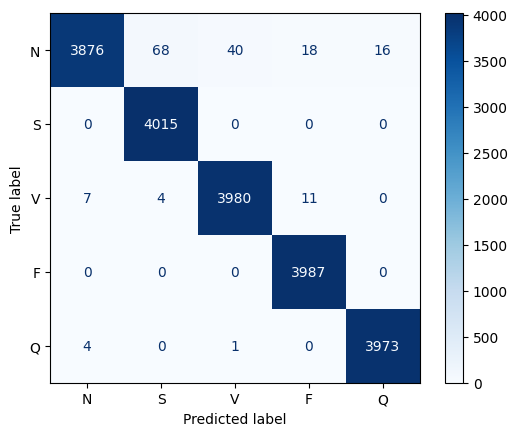

In [ ]:
conf_mat_knn = confusion_matrix(y_valid, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn,  display_labels=labels)
disp.plot(cmap="Blues")

In [ ]:
report_dict_knn = classification_report(y_pred, y_valid, output_dict=True)
report_df_knn = pd.DataFrame(report_dict_knn).transpose()

print('\t'*3 + 'Classification Report of kNN on ValidSet:')
report_df_knn

			Classification Report of kNN on ValidSet:


,precision,recall,f1-score,support
0.0,0.964659,0.997170,0.980645,3887.00000
1.0,1.000000,0.982383,0.991113,4087.00000
2.0,0.994503,0.989804,0.992148,4021.00000
3.0,1.000000,0.992779,0.996376,4016.00000
4.0,0.998743,0.995989,0.997364,3989.00000
accuracy,0.991550,0.991550,0.991550,0.99155
macro avg,0.991581,0.991625,0.991529,20000.00000
weighted avg,0.991776,0.991550,0.991590,20000.00000


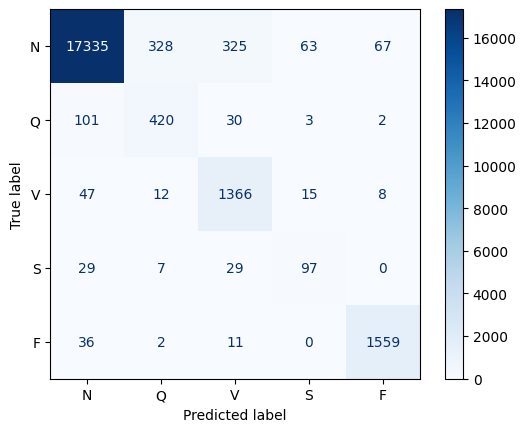

In [ ]:
conf_mat_knn = confusion_matrix(y_test, y_pred_testset)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_knn,  display_labels=labels)
disp.plot(cmap="Blues")

In [ ]:
report_dict_knn = classification_report(y_pred_testset, y_test, output_dict=True)
report_df_knn = pd.DataFrame(report_dict_knn).transpose()

print('\t'*3 + 'Classification Report of kNN on TestSet:')
report_df_knn

			Classification Report of kNN on TestSet:


,precision,recall,f1-score,support
0.0,0.956783,0.987862,0.972074,17548.000000
1.0,0.755396,0.546164,0.633962,769.000000
2.0,0.943370,0.775696,0.851356,1761.000000
3.0,0.598765,0.544944,0.570588,178.000000
4.0,0.969527,0.952934,0.961159,1636.000000
accuracy,0.949068,0.949068,0.949068,0.949068
macro avg,0.844768,0.761520,0.797828,21892.000000
weighted avg,0.946672,0.949068,0.946407,21892.000000


# **Support Vector Machine (SVM) Model**


It is a supervised machine learning algorithm which can be used for both classification and regression problems. However, it is mostly used in classification applications. • The classification is performed by finding the hyperplane that best separates the two classes.

    Select the hyper-plane which separate the two classes better.
    Maximizing the distance between nearest data point (either class) and the hyper-plane. This distance is called Margin.
    Margin: it is the distance between the hyperplane and the observations closest to the hyperplane (support vectors).
    Support Vectors: These are the points that are closest to the hyperplane. A separating line will be defined with the help of these data points.



In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [ ]:
svm_classifier = svm.SVC(kernel='rbf', random_state=42)
svm_classifier.fit(x_train_normalized, y_train)

y_pred_valid = svm_classifier.predict(x_valid_normalized)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

Validation Accuracy: 0.94375


In [ ]:
y_pred_test = svm_classifier.predict(x_test_normalized)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.8918783117120409


In [ ]:
report_dict_knn = classification_report(y_valid, y_pred_valid, output_dict=True)
report_df_knn = pd.DataFrame(report_dict_knn).transpose()

print('\t'*3 + 'Classification Report of SVM on ValidSet:')
report_df_knn

			Classification Report of kNN on ValidSet:


,precision,recall,f1-score,support
0.0,0.886236,0.905426,0.895728,4018.00000
1.0,0.945317,0.899875,0.922036,4015.00000
2.0,0.973344,0.939780,0.956267,4002.00000
3.0,0.926961,0.989967,0.957429,3987.00000
4.0,0.991141,0.984414,0.987766,3978.00000
accuracy,0.943750,0.943750,0.943750,0.94375
macro avg,0.944600,0.943893,0.943845,20000.00000
weighted avg,0.944511,0.943750,0.943730,20000.00000


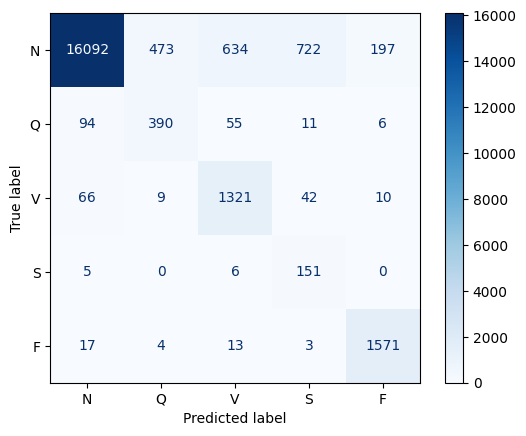

In [ ]:
conf_mat_svm = confusion_matrix(y_test, y_pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_svm,  display_labels=labels)
disp.plot(cmap="Blues")

# **Decision Tree (DT) Model**

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
clf_dt = DecisionTreeClassifier(random_state=42)

clf_dt.fit(x_train_normalized, y_train)
y_pred_valid = clf_dt.predict(x_valid_normalized)

accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

Validation Accuracy: 0.9815


In [ ]:
report_dict_knn = classification_report(y_valid, y_pred_valid, output_dict=True)
report_df_knn = pd.DataFrame(report_dict_knn).transpose()

print('\t'*3 + 'Classification Report of DT on ValidSet:')
report_df_knn

			Classification Report of DT on ValidSet:


,precision,recall,f1-score,support
0.0,0.990107,0.921603,0.954627,4018.0000
1.0,0.969573,1.000000,0.984551,4015.0000
2.0,0.971534,0.989255,0.980314,4002.0000
3.0,0.991298,1.000000,0.995630,3987.0000
4.0,0.986077,0.996983,0.991500,3978.0000
accuracy,0.981500,0.981500,0.981500,0.9815
macro avg,0.981718,0.981568,0.981325,20000.0000
weighted avg,0.981704,0.981500,0.981282,20000.0000


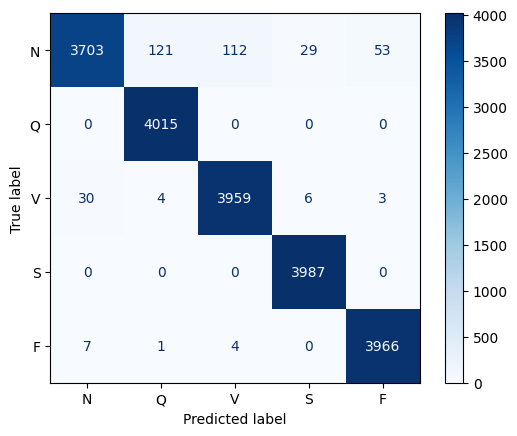

In [ ]:
conf_mat_dt = confusion_matrix(y_valid, y_pred_valid)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_dt,  display_labels=labels)
disp.plot(cmap="Blues")

In [ ]:
y_pred_test_dt = clf_dt.predict(x_test_normalized)

accuracy_test = accuracy_score(y_test, y_pred_test_dt)
print("Test Accuracy:", accuracy_test)

Test Accuracy: 0.7734788964005116


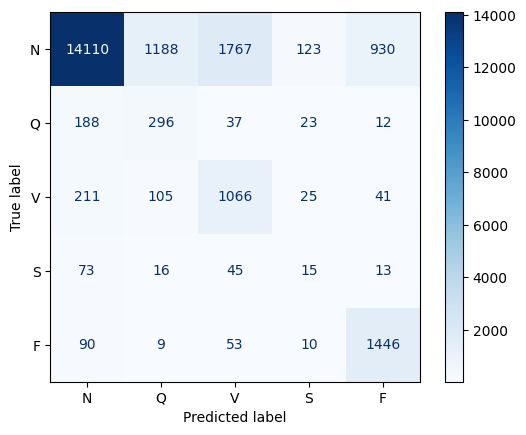

In [ ]:
conf_mat_dt = confusion_matrix(y_test, y_pred_test_dt)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat_dt,  display_labels=labels)
disp.plot(cmap="Blues")

# **Deep Learning**

This neural network combines both Convolutional Neural Network (CNN) and Recurrent Neural Network (RNN) with Long Short-Term Memory (LSTM) layers. And at the end data flows though Dense Layers.

## **CNN + RNN + Dense Layer**

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
print(x_train_normalized.shape)
print(y_train.shape)

(80000, 187)
(80000,)


In [ ]:
x_train_normalized1 = x_train_normalized.reshape((x_train_normalized.shape[0], x_train_normalized.shape[1], 1))
print(x_train_normalized.shape)
print(y_train.shape)

(80000, 187)
(80000,)


In [ ]:
print("x_train_normalized shape:",x_train_normalized1.shape)
print("y_train shape:", y_train.shape)
print("x_valid_normalized shape:", x_valid_normalized.shape)
print("y_valid shape:", y_valid.shape)
print("x_test_normalized shape:", x_test_normalized.shape)
print("y_test shape:", y_test.shape)

y_train = np.array(y_train).reshape(-1)
y_valid = np.array(y_valid).reshape(-1)
y_test = np.array(y_test).reshape(-1)


print("Reshaped y_train shape:", y_train.shape)
print("Reshaped y_valid shape:", y_valid.shape)
print("Reshaped y_test shape:", y_test.shape)

# One-hot encode
num_classes = 5
y_train_one_hot = to_categorical(y_train, num_classes=num_classes)
y_valid_one_hot = to_categorical(y_valid, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)


print("One-hot encoded y_train shape:", y_train_one_hot.shape)
print("One-hot encoded y_valid shape:", y_valid_one_hot.shape)
print("One-hot encoded y_test shape:", y_test_one_hot.shape)


print("Sample one-hot encoded y_train:", y_train_one_hot[:5])

x_train_normalized shape: (80000, 187, 1)
y_train shape: (80000,)
x_valid_normalized shape: (20000, 187)
y_valid shape: (20000,)
x_test_normalized shape: (21892, 187)
y_test shape: (21892,)
Reshaped y_train shape: (80000,)
Reshaped y_valid shape: (20000,)
Reshaped y_test shape: (21892,)
One-hot encoded y_train shape: (80000, 5)
One-hot encoded y_valid shape: (20000, 5)
One-hot encoded y_test shape: (21892, 5)
Sample one-hot encoded y_train: [[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model

In [ ]:
model_cnn_lstm = Sequential([

    Input(shape=(x_train_normalized1[1], x_train_normalized1[2])),
    Conv1D(64, kernel_size=6, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=3, strides=2, padding="same"),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding="same"),

    Conv1D(64, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPool1D(pool_size=2, strides=2, padding="same"),

    LSTM(64, return_sequences=True, activation="tanh"),

    LSTM(32, activation="tanh"),

    Flatten(),

    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

NameError: name 'Sequential' is not defined

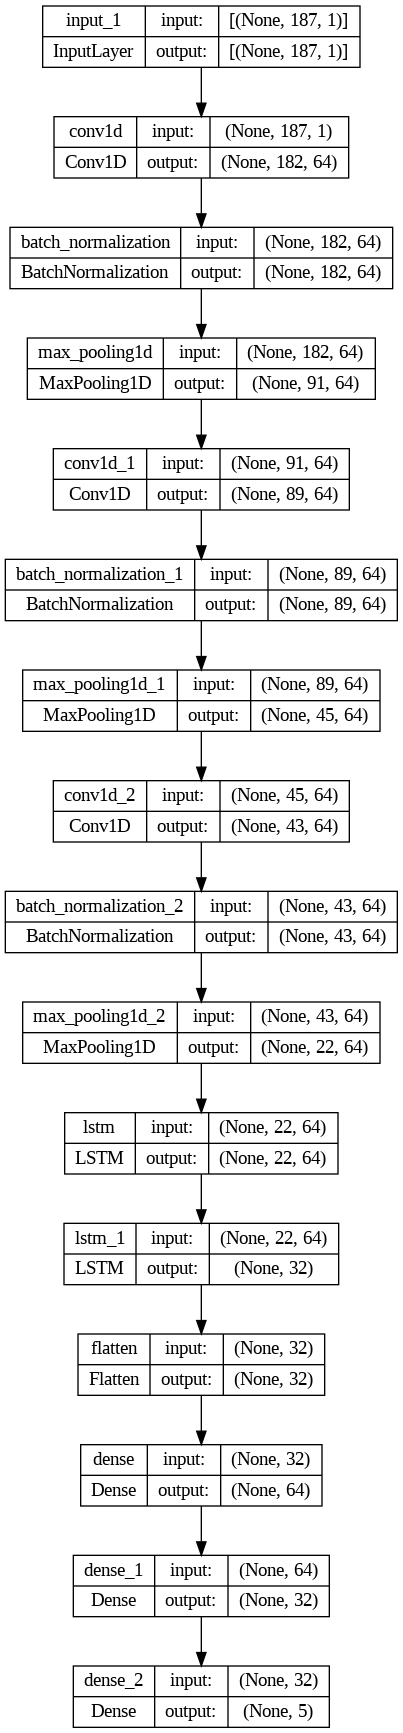

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_cnn_lstm, to_file='FNN_model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
model_cnn_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

tf.config.run_functions_eagerly(True)


history = model_cnn_lstm.fit(x_train_normalized1, y_train_one_hot,
                             epochs=10,
                             callbacks=callbacks,
                             batch_size=32,
                             validation_data=(x_valid_normalized, y_valid_one_hot))

tf.config.run_functions_eagerly(False)

Epoch 1/10
2500/2500 [==============================] - 845s 337ms/step - loss: 0.3748 - accuracy: 0.8686 - val_loss: 0.2215 - val_accuracy: 0.9224
Epoch 2/10
2500/2500 [==============================] - 828s 331ms/step - loss: 0.1731 - accuracy: 0.9406 - val_loss: 0.1312 - val_accuracy: 0.9570
Epoch 3/10
2500/2500 [==============================] - 834s 334ms/step - loss: 0.1233 - accuracy: 0.9583 - val_loss: 0.1175 - val_accuracy: 0.9596
Epoch 4/10
2500/2500 [==============================] - 825s 330ms/step - loss: 0.0930 - accuracy: 0.9686 - val_loss: 0.0937 - val_accuracy: 0.9674
Epoch 5/10
2500/2500 [==============================] - 826s 330ms/step - loss: 0.0769 - accuracy: 0.9742 - val_loss: 0.0654 - val_accuracy: 0.9774
Epoch 6/10
2500/2500 [==============================] - 835s 334ms/step - loss: 0.0627 - accuracy: 0.9795 - val_loss: 0.0824 - val_accuracy: 0.9743
Epoch 7/10
2500/2500 [==============================] - 854s 342ms/step - loss: 0.0564 - accuracy: 0.9819 - val_

TypeError: enable_debug_mode() takes 0 positional arguments but 1 was given

In [ ]:
save_dir = r'C:\Users\drago\Desktop\ML Project'
model_filename = 'model_CNN_ECG.keras'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Construct the full save path
save_path = os.path.join(save_dir, model_filename)

# Save the model
#model_cnn_lstm.save('model_cnn_lstm.keras')

In [ ]:
model_cnn_lstm = load_model('/content/model_CNN_ECG.keras')

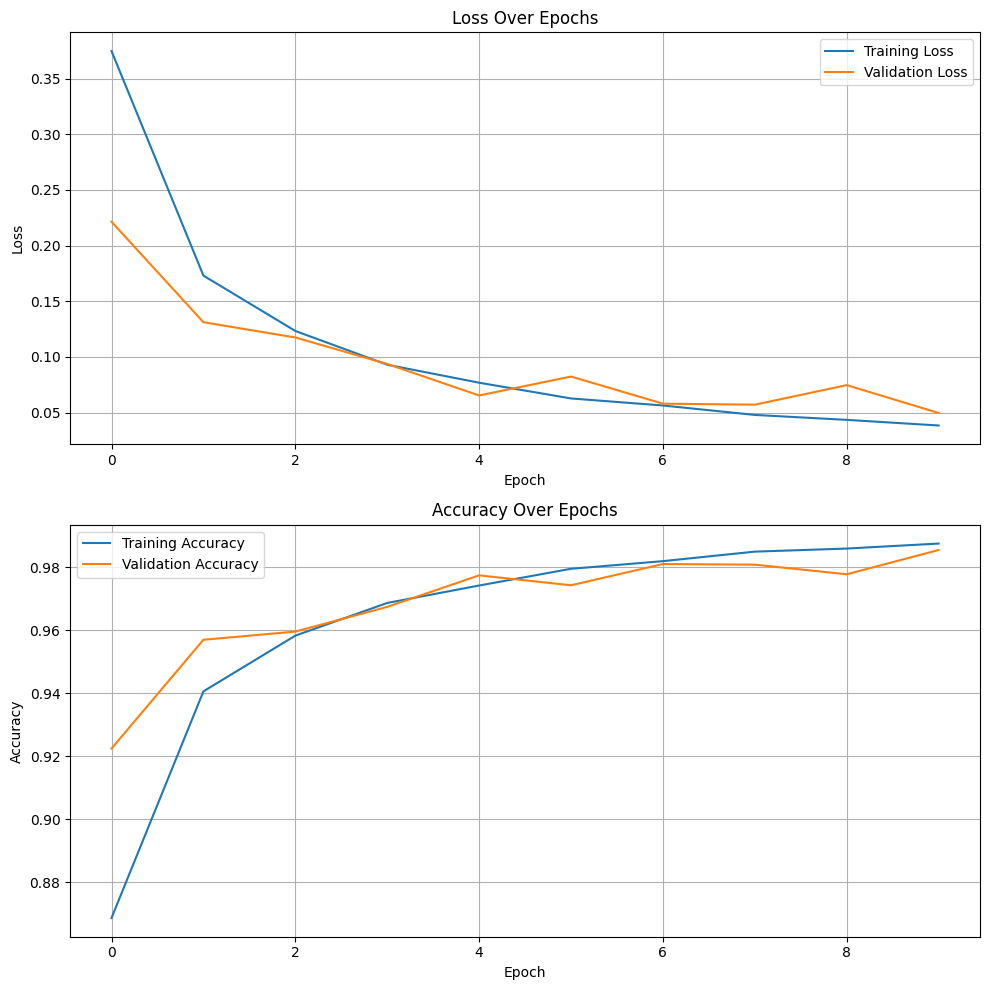

In [ ]:
fig, axs = plt.subplots(2, figsize=(10, 10))

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
x_test_normalized = x_test_normalized.reshape((x_test_normalized.shape[0], x_test_normalized.shape[1], 1))

In [ ]:
train_score = model_cnn_lstm.evaluate(x_train_normalized, y_train_one_hot)
validation_score = model_cnn_lstm.evaluate(x_valid_normalized, y_valid_one_hot)

print('Accuracy train data: ', validation_score[1])
print('Accuracy Test data: ', train_score[1])

625/625 [==============================] - 16s 26ms/step - loss: 0.0497 - accuracy: 0.9855
Accuracy train data:  0.985450029373169
Accuracy Test data:  0.9901624917984009


In [ ]:
y_pred = model_cnn_lstm.predict(x_test_normalized)

685/685 [==============================] - 12s 17ms/step


In [ ]:
from sklearn.metrics import classification_report

y_test_one_hot_labels = np.argmax(y_test_one_hot, axis = 1)
y_pred_labels = np.argmax(y_pred, axis = 1)
conf_matrix_nn = classification_report(y_test_one_hot_labels, y_pred_labels)
print(conf_matrix_nn)

              precision    recall  f1-score   support

           0       0.99      0.94      0.97     18118
           1       0.45      0.81      0.58       556
           2       0.80      0.95      0.87      1448
           3       0.42      0.65      0.51       162
           4       0.92      0.98      0.95      1608

    accuracy                           0.94     21892
   macro avg       0.72      0.87      0.77     21892
weighted avg       0.95      0.94      0.94     21892



In [ ]:
output_percentagetest = df_test_un.iloc[:, 187].value_counts()
output_percentagetest

187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64